In [1]:
#######################
## NODE MINI-PROJECT ##
#######################

## Goals:
## (1) Develop a framework for fitting NODEs in pytorch using TorchDiffEqFlux.
## (2) Apply the framework to fit the hare-lynx time series of prey-predator oscillations.
## (3) Analyse the dynamics of hare and lynx (e.g. how does a change in the number of predators impact the prey dynamics? Are their non-linearities in the dynamics?).
## (4) Assess the capacity of the framework to forecast future dynamics and past dynamics.
## (5) Explore alternative models (e.g. NODEs with additional latent states and/or explicit temporal dependence of dynamics).

## Author: Willem Bonnaffé (w.bonnaffe@gmail.com)

#
###

In [2]:
####################
## INITIALIZATION ##
####################

## Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchdiffeq import odeint
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

## Set random seed for reproducibility
torch.manual_seed(0)

#
###

/Users/willembonnaffe/anaconda3/envs/pytorch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


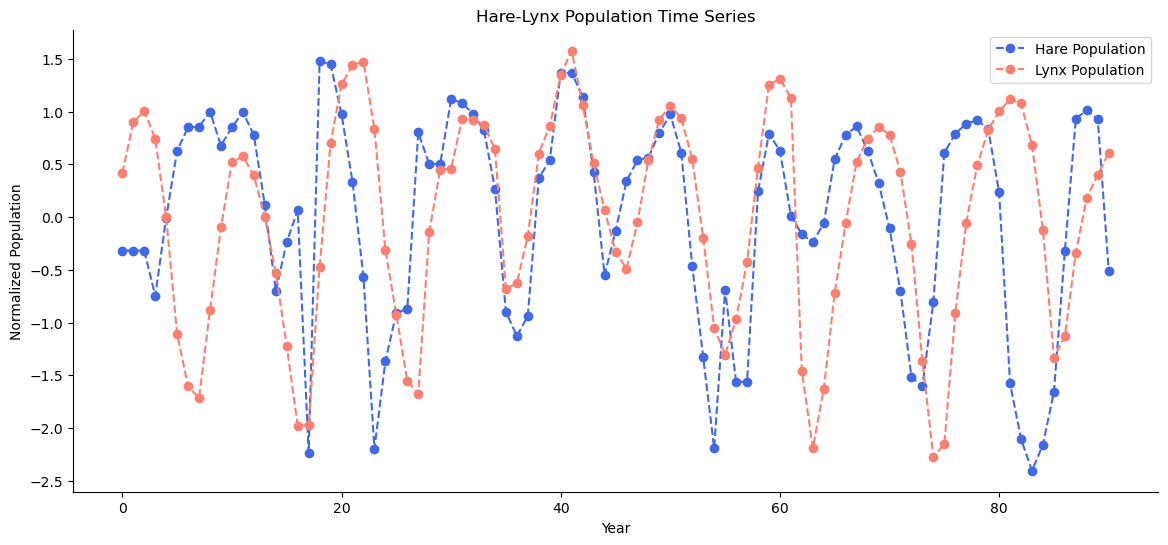

In [3]:
################################
## LOADING AND EXPLORING DATA ##
################################

## Goal:
## Load and preprocess the Hudson Bay Company’s hare-lynx dataset, visualize basic trends, and normalize data for model training.

## Load data function
## Goal:
## Load the hare-lynx dataset from a CSV file and preprocess for NODE training.
## Inputs:
## file_path (str): Path to the CSV file containing hare-lynx time series data.
## Outputs:
## data_tensor (torch.Tensor): Normalized hare-lynx population data as a PyTorch tensor.
def load_and_preprocess_data(file_path):

    ## Load the data
    data = np.array(pd.read_csv(file_path))
    data = data[:,1:3] # Drop time step

    ## Subset time steps
    # data = data[0:30]

    ## Normalize data to stabilize training
    data_normalized = np.copy(data)
    for i in range(data.shape[1]):
        data_log = np.log(data[:,i])
        data_normalized[:,i] = (data_log - data_log.mean()) / data_log.std()
    
    ## Convert data to PyTorch tensor
    data_tensor = torch.tensor(data_normalized, dtype=torch.float32)
    
    return data_tensor

## Load and visualize the data
data_tensor = load_and_preprocess_data('data_hare_lynx.csv')
num_time_steps = data_tensor.size()[0]
data_tensor = data_tensor.float()

## Plot the data to observe trends in hare and lynx populations
plt.figure(figsize=(14,6))
plt.plot(data_tensor[:, 0], '--o', label='Hare Population', color='royalblue')
plt.plot(data_tensor[:, 1], '--o', label='Lynx Population', color='salmon')
plt.xlabel('Year')
plt.ylabel('Normalized Population')
plt.legend()
plt.title('Hare-Lynx Population Time Series')
sns.despine()
plt.show()

#
###

/var/folders/cc/s3dds93958xg4bd9skl7n5500000gn/T/ipykernel_28892/2251727208.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(hare_density, lynx_density, time_steps, color=colors, marker='o', s=10, cmap='jet')


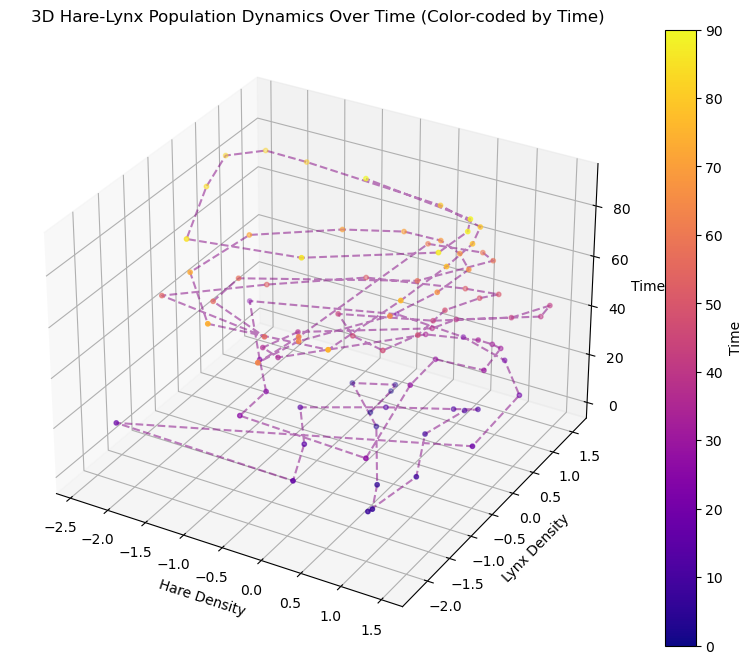

In [4]:
##############################################
## 3D VISUALIZATION OF HARE-LYNX POPULATION ##
##############################################

## Goal:
## Visualize the hare and lynx population densities over time in a 3D plot with time on the z-axis.
## The line color changes according to the time axis, with early time points in blue and later time points in red.

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

## Prepare data for 3D plot
hare_density = data_tensor[:, 0].numpy()  # Hare population density
lynx_density = data_tensor[:, 1].numpy()  # Lynx population density
time_steps = np.arange(num_time_steps)    # Time steps

## Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

## Normalize time steps for color mapping
norm = plt.Normalize(time_steps.min(), time_steps.max())
colors = cm.plasma(norm(time_steps))  # Use 'plasma' colormap for gradient from blue to red

## Plot each point in the time series with color corresponding to time
ax.plot(hare_density, lynx_density, time_steps, '--', color='purple', alpha=0.5)
ax.scatter(hare_density, lynx_density, time_steps, color=colors, marker='o', s=10, cmap='jet')

## Set axis labels and title
ax.set_xlabel('Hare Density')
ax.set_ylabel('Lynx Density')
ax.set_zlabel('Time')
ax.set_title('3D Hare-Lynx Population Dynamics Over Time (Color-coded by Time)')

## Display color bar for reference
mappable = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
mappable.set_array(time_steps)
fig.colorbar(mappable, ax=ax, label="Time")

plt.show()

#
###


# Standard NODE

In [15]:
#######################
## DEFINE NODE MODEL ##
#######################

## Goal:
## Define the Neural ODE (NODE) model to capture dynamics of hare and lynx populations using a simple feed-forward neural network.

## NODE model class
## Goal:
## Define a neural network representing the ODE function for hare-lynx populations.
## Inputs:
## N/A
## Outputs:
## dX/dt (torch.Tensor): Derivative of hare and lynx populations.
class PredatorPreyODE(nn.Module):

    def __init__(self):
        super(PredatorPreyODE, self).__init__()

        ## Define a small feed-forward neural network with one hidden layer
        self.net = nn.Sequential(
            nn.Linear(2, 50),   # Input layer with two variables: hare and lynx populations
            nn.Tanh(),
            nn.Linear(50, 2)    # Output layer with two outputs: dHare/dt and dLynx/dt
        )

    def forward(self, t, x):
        return self.net(x)

#
###

In [4]:
######################
## INITIALISE MODEL ##
######################

## Goal:
## Initialise the NODE model and verify that it produces outputs of the expected dimensions.

## Instantiate the model
predator_prey_ode = PredatorPreyODE()

## Test the model with an initial condition (e.g., starting hare and lynx population values)
initial_population = data_tensor[0]  # Starting values from data
time_points = torch.linspace(0, num_time_steps, steps=num_time_steps)  # Placeholder time points for testing

## Run the model to test output shapes
with torch.no_grad():
    output = odeint(predator_prey_ode, initial_population, time_points)

## Verify output dimensions
print("Model output shape:", output.shape)  # Expected shape: (10, 2) for 10 time points and 2 population variables

#
###

Model output shape: torch.Size([91, 2])


In [5]:
##########################
## MODEL TRAINING SETUP ##
##########################

## Goal:
## Set up loss function, optimizer, and training loop parameters for NODE model.

## Define the mean squared error (MSE) loss function for training
mse_loss = nn.MSELoss()

## Initialize optimizer
## Goal:
## Use the Adam optimizer to adjust model weights for minimizing the loss.
optimizer = optim.Adam(predator_prey_ode.parameters(), lr=0.001)

## Training parameters
num_epochs = 1000  # Total number of epochs for model training

#
###

In [6]:
#######################################
## FUNCTIONS TRAINING AND EVALUATION ##
#######################################

## Goal:
## Implement the training loop to optimize the NODE model's fit to the hare-lynx population data.

## training_loop function
## Goal:
## Train the NODE model over a specified number of epochs, minimizing MSE between model predictions and observed data.
## Inputs:
## model (nn.Module): The NODE model to be trained.
## optimizer (torch.optim.Optimizer): Optimizer for adjusting model weights.
## data (torch.Tensor): Time series data of hare and lynx populations.
## epochs (int): Number of epochs to run the training loop.
## Outputs:
## None
def training_loop(model, optimizer, data, epochs):

    # model.train()
    # model.eval()

    ## Get time steps of data
    time_points = torch.linspace(0, data.shape[0], steps=data.shape[0])  # Time points based on data length

    for epoch in range(epochs):

        ## Set gradients to zero before each pass
        optimizer.zero_grad()

        ## Forward pass: use ODE solver to predict populations over time
        predicted_population = odeint(model, data[0], time_points)

        ## Compute loss as MSE between predicted and actual data
        loss = mse_loss(predicted_population, data)

        ## Backward pass: compute gradients and update model parameters
        loss.backward()
        optimizer.step()

        ## Log training progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

## evaluate_model function
## Goal:
## Evaluate the NODE model by comparing its predictions to the actual data and calculating final loss.
## Inputs:
## model (nn.Module): The trained NODE model.
## data (torch.Tensor): Time series data of hare and lynx populations.
## Outputs:
## final_loss (float): Final MSE loss after model training.
def evaluate_model(model, data):

    ## Get time steps of data
    time_points = torch.linspace(0, data.shape[0], steps=data.shape[0])  # Time points based on data length
    
    ## Perform forward pass to get model predictions
    predicted_population = odeint(model, data[0], time_points)

    ## Calculate final MSE loss on the dataset
    final_loss = mse_loss(predicted_population, data).item()
    print(f"Final Loss: {final_loss:.4f}")

    ## Visualize the results
    plt.figure(figsize=(14,6))
    plt.plot(data[:, 0], '--o', label="True Hare Population", color='royalblue')
    plt.plot(data[:, 1], '--o', label="True Lynx Population", color='salmon')
    plt.plot(predicted_population[:, 0].detach(), '-', label="Predicted Hare Population", color='royalblue')
    plt.plot(predicted_population[:, 1].detach(), '-', label="Predicted Lynx Population", color='salmon')
    plt.xlabel('Year')
    plt.ylabel('Normalized Population')
    plt.legend()
    plt.title('True vs Predicted Hare-Lynx Population Dynamics')
    sns.despine()
    plt.show()

    return final_loss

#
###

Epoch 0/1000, Loss: 0.3777
Epoch 100/1000, Loss: 0.2868
Epoch 200/1000, Loss: 0.2791
Epoch 300/1000, Loss: 0.2734
Epoch 400/1000, Loss: 0.2686
Epoch 500/1000, Loss: 0.2642
Epoch 600/1000, Loss: 0.2600
Epoch 700/1000, Loss: 0.2558
Epoch 800/1000, Loss: 0.2516
Epoch 900/1000, Loss: 0.2473
Final Loss: 0.2429


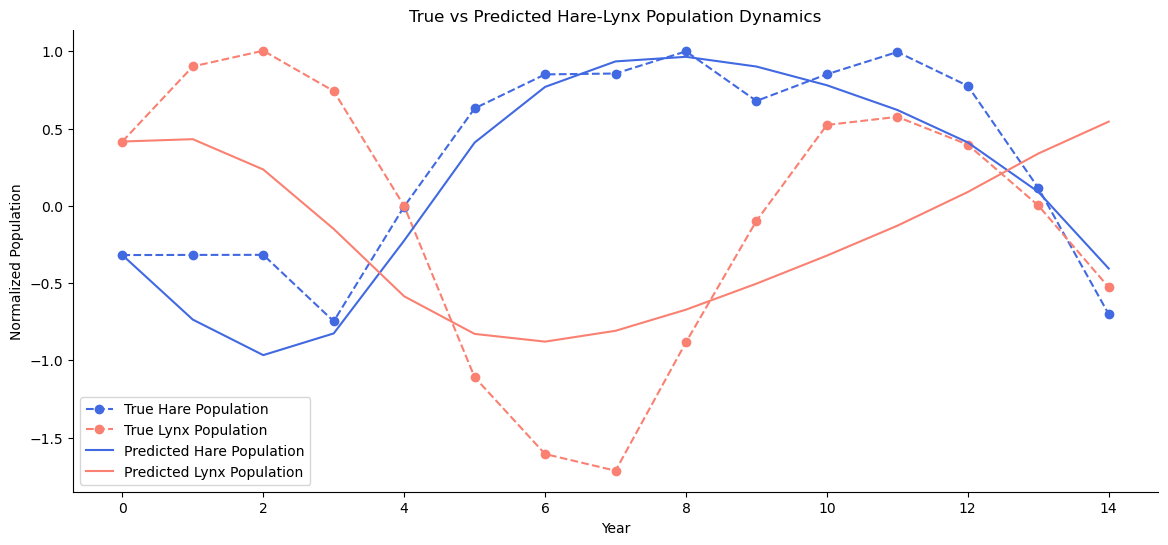

In [19]:
#####################################
## RUNNING TRAINING AND EVALUATION ##
#####################################

## Goal:
## Execute the training loop and evaluate the NODE model on the hare-lynx dataset.

## Run training loop
training_loop(model=predator_prey_ode, optimizer=optimizer, data=data_tensor[0:15], epochs=num_epochs)
training_loop(model=predator_prey_ode, optimizer=optimizer, data=data_tensor[0:30], epochs=num_epochs)
training_loop(model=predator_prey_ode, optimizer=optimizer, data=data_tensor[0:60], epochs=num_epochs)

## Evaluate model after training
final_loss = evaluate_model(predator_prey_ode, data_tensor)

#
###

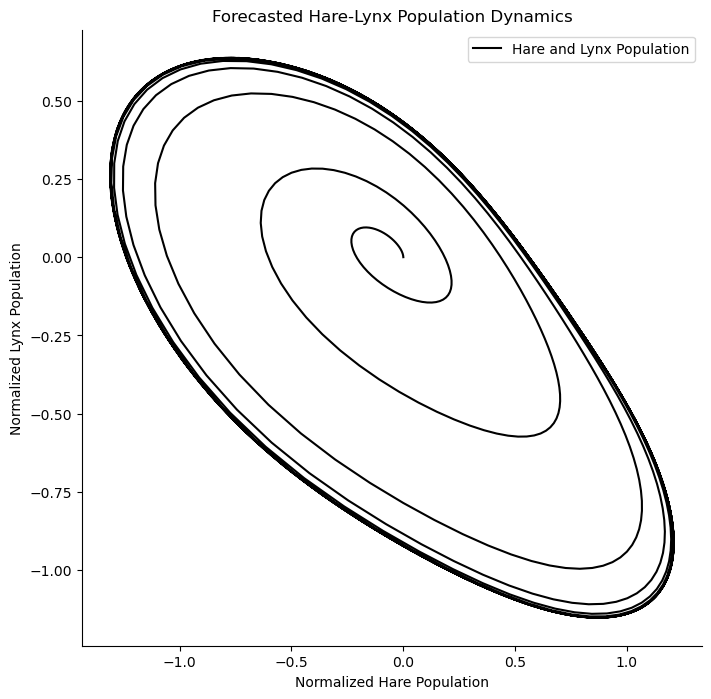

In [27]:
##########################################
## VISUALISATION OF PREY-PREDATOR CYCLE ##
##########################################

## Define time steps for forecasting beyond training data range
forecast_time_steps = torch.linspace(0, num_time_steps * 2, steps=num_time_steps * 10)  # Forecast for twice the time range as training data

## Perform forecasting
initial_states = torch.tensor([0,0]).float()
forecasted_population = odeint(predator_prey_ode, initial_states, forecast_time_steps)

## Visualize forecasted populations
plt.figure(figsize=(8,8))
plt.plot(forecasted_population[:, 0].detach(), forecasted_population[:, 1].detach(), '-', label="Hare and Lynx Population", color='black')
plt.xlabel('Normalized Hare Population')
plt.ylabel('Normalized Lynx Population')
plt.legend()
plt.title('Forecasted Hare-Lynx Population Dynamics')
sns.despine()
plt.show()

#
###

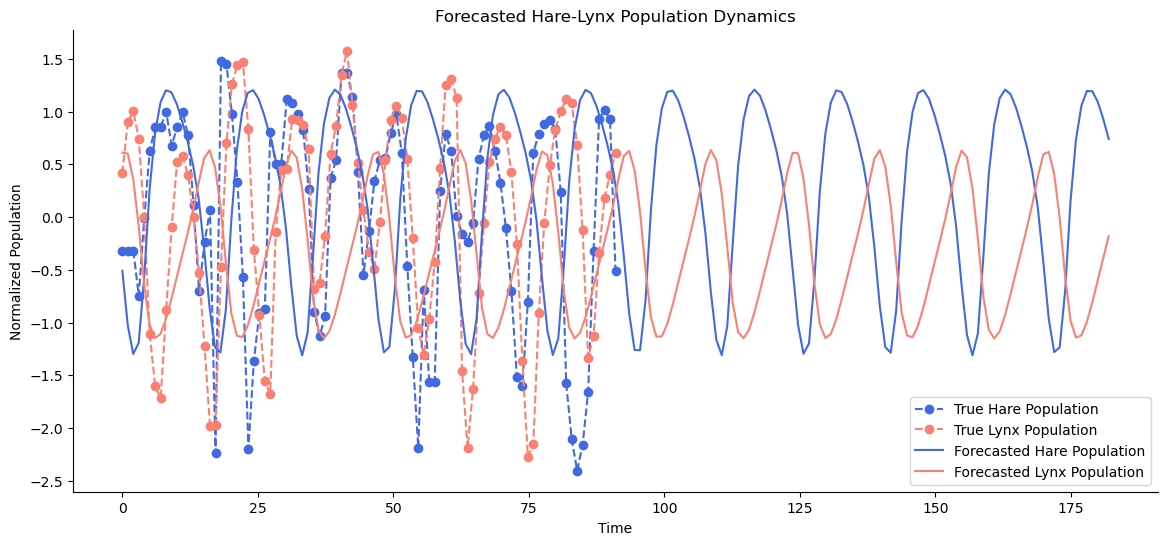

In [28]:
##########################
## FORECASTING ANALYSIS ##
##########################

## Goal:
## Test the NODE model's ability to forecast future hare and lynx population dynamics.

## Define time steps for forecasting beyond training data range
time_steps = torch.linspace(0, num_time_steps, steps=num_time_steps)
forecast_time_steps = torch.linspace(0, num_time_steps * 2, steps=num_time_steps * 2)  # Forecast for twice the time range as training data

## Perform forecasting
forecasted_population = odeint(predator_prey_ode, data_tensor[-1], forecast_time_steps)

## Visualize forecasted populations
plt.figure(figsize=(14,6))
plt.plot(time_steps, data_tensor[:, 0], '--o', label="True Hare Population", color='royalblue')
plt.plot(time_steps, data_tensor[:, 1], '--o', label="True Lynx Population", color='salmon')
plt.plot(forecast_time_steps, forecasted_population[:, 0].detach(), '-', label="Forecasted Hare Population", color='royalblue')
plt.plot(forecast_time_steps, forecasted_population[:, 1].detach(), '-', label="Forecasted Lynx Population", color='salmon')
plt.xlabel('Time')
plt.ylabel('Normalized Population')
plt.legend()
plt.title('Forecasted Hare-Lynx Population Dynamics')
sns.despine()
plt.show()

#
###

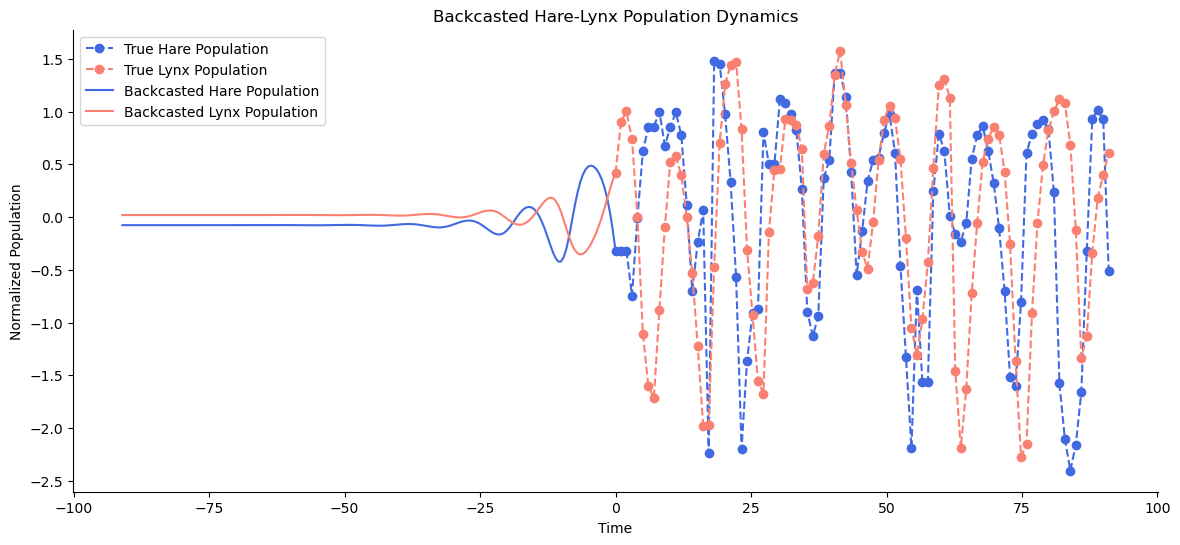

In [29]:
##########################
## BACKCASTING ANALYSIS ##
##########################

## Goal:
## Test the NODE model's ability to backcast previous hare and lynx population dynamics by integrating backwards in time.

## Define time steps for backcasting prior to the training data range
time_steps = torch.linspace(0, num_time_steps, steps=num_time_steps)
backcast_time_steps = torch.linspace(0, -num_time_steps, steps=num_time_steps * 2)  # Backcast by integrating backwards in time

## Perform backcasting
## Start from the latest observed population values in the dataset (data_tensor[-1])
backcasted_population = odeint(predator_prey_ode, data_tensor[0], backcast_time_steps)

## Visualize backcasted populations
plt.figure(figsize=(14,6))
plt.plot(time_steps, data_tensor[:, 0], '--o', label="True Hare Population", color='royalblue')
plt.plot(time_steps, data_tensor[:, 1], '--o', label="True Lynx Population", color='salmon')
plt.plot(backcast_time_steps, backcasted_population[:, 0].detach(), '-', label="Backcasted Hare Population", color='royalblue')
plt.plot(backcast_time_steps, backcasted_population[:, 1].detach(), '-', label="Backcasted Lynx Population", color='salmon')
plt.xlabel('Time')
plt.ylabel('Normalized Population')
plt.legend()
plt.title('Backcasted Hare-Lynx Population Dynamics')
sns.despine()
plt.show()

#
###


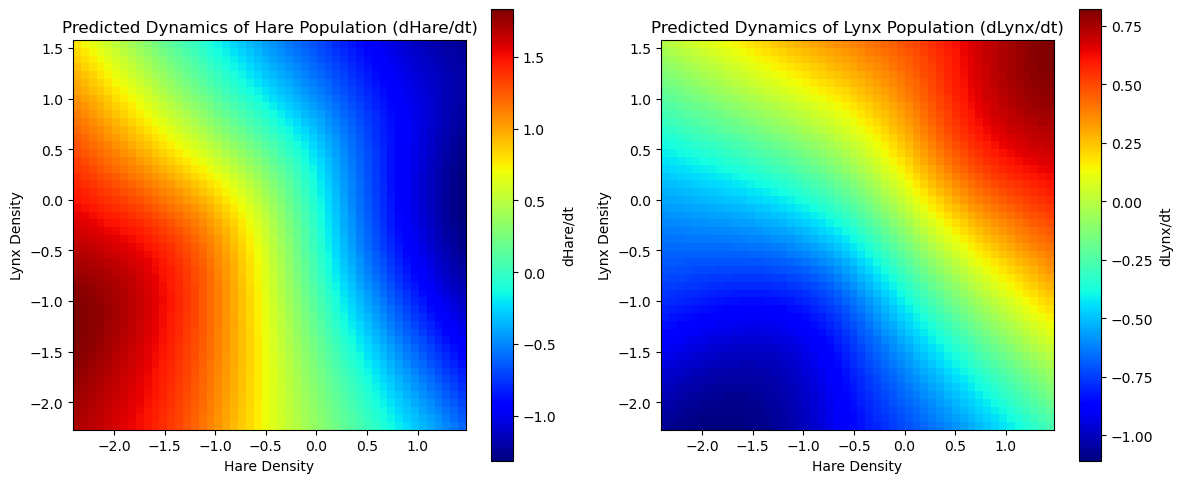

In [30]:
#######################################
## ANALYSIS: PREDICTED DYNAMICS GRID ##
#######################################

## Goal:
## Analyze the NODE model's dynamics by evaluating it over a grid of hare and lynx densities. 
## Display two heatmaps showing the predicted dynamics of hare and lynx populations.

import numpy as np
import matplotlib.pyplot as plt

## dynamics_grid_analysis function
## Goal:
## Evaluate NODE model dynamics over a grid of hare and lynx densities, and plot heatmaps of predicted dynamics.
## Inputs:
## model (nn.Module): Trained NODE model (with or without latent variable).
## hare_range (tuple of float): Range of hare densities to evaluate (min, max).
## lynx_range (tuple of float): Range of lynx densities to evaluate (min, max).
## grid_size (int): Number of points along each axis in the grid (default=50).
## Outputs:
## None
def dynamics_grid_analysis(model, hare_range, lynx_range, grid_size=50):
    
    ## Create mesh grid for hare and lynx densities
    hare_values = np.linspace(hare_range[0], hare_range[1], grid_size)
    lynx_values = np.linspace(lynx_range[0], lynx_range[1], grid_size)
    hare_grid, lynx_grid = np.meshgrid(hare_values, lynx_values)

    ## Initialize arrays to store dynamics predictions for each grid point
    hare_dynamics = np.zeros((grid_size, grid_size))
    lynx_dynamics = np.zeros((grid_size, grid_size))
    
    ## Evaluate dynamics across the grid
    for i in range(grid_size):
        for j in range(grid_size):
            ## Prepare hare and lynx populations as a torch tensor for model input
            hare_density = hare_values[i]
            lynx_density = lynx_values[j]
            input_tensor = torch.tensor([hare_density, lynx_density], dtype=torch.float32)

            ## Get dynamics prediction (dHare/dt, dLynx/dt) from the model
            dynamics = model(0, input_tensor)
            
            ## Store the predicted dynamics in the arrays
            hare_dynamics[i, j] = dynamics[0].item() # dHare/dt
            lynx_dynamics[i, j] = dynamics[1].item() # dLynx/dt

    ## Plot heatmap for hare population dynamics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(hare_dynamics, extent=(hare_range[0], hare_range[1], lynx_range[0], lynx_range[1]), origin='lower', cmap='jet')
    plt.colorbar(label='dHare/dt')
    plt.xlabel("Hare Density")
    plt.ylabel("Lynx Density")
    plt.title("Predicted Dynamics of Hare Population (dHare/dt)")

    ## Plot heatmap for lynx population dynamics
    plt.subplot(1, 2, 2)
    plt.imshow(lynx_dynamics, extent=(hare_range[0], hare_range[1], lynx_range[0], lynx_range[1]), origin='lower', cmap='jet')
    plt.colorbar(label='dLynx/dt')
    plt.xlabel("Hare Density")
    plt.ylabel("Lynx Density")
    plt.title("Predicted Dynamics of Lynx Population (dLynx/dt)")

    plt.tight_layout()
    plt.show()


## Running dynamics grid analysis
## Define hare and lynx density ranges based on the observed data
hare_min, hare_max = data_tensor[:, 0].min().item(), data_tensor[:, 0].max().item()
lynx_min, lynx_max = data_tensor[:, 1].min().item(), data_tensor[:, 1].max().item()

## Execute analysis
dynamics_grid_analysis(predator_prey_ode, hare_range=(hare_min, hare_max), lynx_range=(lynx_min, lynx_max))

#
###

In [31]:
##########################
## SENSITIVITY ANALYSIS ##
##########################

## Goal:
## Calculate sensitivities between hare and lynx populations using the Jacobian matrix and visualize their influence on each other's growth rates.

## jacobian_sensitivity function
## Goal:
## Compute the Jacobian matrix at a given time point to assess how hare and lynx populations influence each other's growth rates.
## Inputs:
## model (nn.Module): Trained NODE model.
## population (torch.Tensor): Current hare and lynx populations at a given time point.
## Outputs:
## jacobian_matrix (torch.Tensor): Jacobian matrix representing sensitivities between hare and lynx populations.
def jacobian_sensitivity(model, population):

    ## Enable gradient tracking for sensitivity calculation
    population.requires_grad_(True)
    
    ## Forward pass to get the population derivatives
    population_derivative = model(0, population)

    ## Calculate Jacobian by differentiating derivatives w.r.t. population
    jacobian_matrix = torch.zeros(2, 2)
    for i in range(2):
        jacobian_matrix[i] = torch.autograd.grad(
            population_derivative[i], population, retain_graph=True, create_graph=True)[0]
    
    return jacobian_matrix

## Compute and visualize Jacobian sensitivities
## Select a population value for sensitivity calculation
test_population = data_tensor[0]
jacobian_matrix = jacobian_sensitivity(predator_prey_ode, test_population)

print("Jacobian Matrix (Sensitivity between populations):\n", jacobian_matrix)

#
###

Jacobian Matrix (Sensitivity between populations):
 tensor([[-0.1459, -1.0840],
        [ 0.4528,  0.4960]], grad_fn=<CopySlices>)
